[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Spandan-Madan/generalization_to_OOD_category_viewpoint_cominations/blob/main/demos/separate_vs_shared.ipynb)

# Overview


This demo shows the impact of parameter sharing on out-of-distribution generalization. Specifically, we show how the `SHARED` and `SEPARATE` architectures compare.

As shown below, the `SHARED` architecture enforces parameter sharing between the two tasks (category prediction and viewpoint prediction), and the same weights are learned for all convolutional layers for both tasks. These are followed by two task specific fully connected layers for prediction. On the other hand, the `SEPARATE` architecture does not enforce any parameter sharing - all layers are learned separately for the two tasks.

As described in the paper, our results show that while `SEPARATE` architecture can perform marginally worse on in-distribution combinations, they perform significantly better on out-of-distribution combinations.

`SHARED`             |  `SEPARATE`
:-------------------------:|:-------------------------:
![](https://github.com/Spandan-Madan/generalization_to_OOD_category_viewpoint_cominations/blob/main/docs/images/Shared.png?raw=1)  |  ![](https://github.com/Spandan-Madan/generalization_to_OOD_category_viewpoint_cominations/blob/main/docs/images/Separate.png?raw=1)

In [1]:
import os
def create_folder(path):
    if not os.path.isdir(path):
        os.mkdir(path)

If running on google colab, the below code does the following:
- clone repo
- set up necessary folders
- download MNIST Rotation Dataset at appropriate place
- unzip MNIST Rotation

#### If you're not running on colab, please follow download instructions to get the mnist_rotaiton dataset using:

```
cd utils
bash download_mnist_rotation.sh
```

#### If not using google colab, please proceed below only after downloading the dataset

In [2]:
if 'google.colab' in str(get_ipython()):
    print('Cloning code base to colab....')
    !git clone https://github.com/Spandan-Madan/generalization_to_OOD_category_viewpoint_cominations.git
    !cd generalization_to_OOD_category_viewpoint_cominations/utils && bash download_mnist_rotation.sh
    CODE_ROOT = "generalization_to_OOD_category_viewpoint_cominations/"
else:
    CODE_ROOT = '..'

Cloning code base to colab....
Cloning into 'generalization_to_OOD_category_viewpoint_cominations'...
remote: Enumerating objects: 944, done.
remote: Counting objects: 100% (944/944), done.
remote: Compressing objects: 100% (583/583), done.
remote: Total 944 (delta 497), reused 786 (delta 348), pack-reused 0
Receiving objects: 100% (944/944), 232.54 MiB | 15.89 MiB/s, done.
Resolving deltas: 100% (497/497), done.
Checking out files: 100% (126/126), done.
--2022-04-01 17:59:30--  https://www.dropbox.com/s/wdws3b3fjo190sk/self_generated.tar.gz?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/wdws3b3fjo190sk/self_generated.tar.gz [following]
--2022-04-01 17:59:30--  https://www.dropbox.com/s/raw/wdws3b3fjo190sk/self_generated.tar.gz
Reusing existing connection to www.dropbox.com:443.
HT

In [3]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
import os
from PIL import ImageFile
import random
ImageFile.LOAD_TRUNCATED_IMAGES = True
import argparse
import pickle
import sys
sys.path.append('%s/res/'%CODE_ROOT)
from models.models import get_model
from loader.loader import get_loader

/content
generalization_to_OOD_category_viewpoint_cominations//res/loader/loader.py
generalization_to_OOD_category_viewpoint_cominations//res/loader


In [4]:
from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("poster")
sns.set_palette("Set1", 8, .75)
sns.despine()

<Figure size 432x288 with 0 Axes>

In [5]:
DATASET_NAME = 'mnist_rotation_six_by_nine'
NUM_EPOCHS = 10
BATCH_SIZE = 200
ARCH = 'LATE_BRANCHING_COMBINED'

image_transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])


GPU = 1

In [6]:
NUM_CLASSES = (10,10,10,10)
loader_new = get_loader('multi_attribute_loader_file_list_mnist_rotation')

file_list_root = '%s/dataset_lists/mnist_rotation_lists/'%CODE_ROOT
att_path = '%s/dataset_lists/combined_attributes.p'%CODE_ROOT

In [7]:
shuffles = {'train':True,'val':True,'test':False}

In [8]:
data_dir = '%s/data/'%CODE_ROOT

In [9]:
file_lists = {}
dsets = {}
dset_loaders = {}
dset_sizes = {}
for phase in ['train','val','test']:
    file_lists[phase] = "%s/%s_list_%s.txt"%(file_list_root,phase,DATASET_NAME)
    dsets[phase] = loader_new(file_lists[phase],att_path, image_transform, data_dir)
    dset_loaders[phase] = torch.utils.data.DataLoader(dsets[phase], batch_size=BATCH_SIZE, shuffle = shuffles[phase], num_workers=2,drop_last=True)
    dset_sizes[phase] = len(dsets[phase])

In [10]:
multi_losses = [nn.CrossEntropyLoss(),nn.CrossEntropyLoss(),nn.CrossEntropyLoss(),nn.CrossEntropyLoss()]

In [11]:
def weight_scheduler(epoch_num, task):
    if task == 'shared':
        return [0.0,1.0,0.0,1.0]
    elif task == 'viewpoint':
        return [0.0,1.0,0.0,0.0]
    elif task == 'category':
        return [0.0,0.0,0.0,1.0]

In [12]:
def train_epoch(model, task, optimizer):
    model.train()
    torch.set_grad_enabled(True)
    phase = 'train'
    
    weights = weight_scheduler(epoch, task)
    iters = 0
    phase_epoch_corrects = [0,0,0,0]
    phase_epoch_loss = 0
    
    for data in tqdm(dset_loaders[phase]):
        inputs, labels_all, paths = data
        inputs = Variable(inputs.float().cuda())

        optimizer.zero_grad()
        model_outs = model(inputs)
        calculated_loss = 0
        batch_corrects = [0,0,0,0]
        
        for i in range(4):
            labels = labels_all[:,i]
            if GPU:
                labels = Variable(labels.long().cuda())
            loss = multi_losses[i]
            outputs = model_outs[i]
            calculated_loss += weights[i] * loss(outputs,labels)
            _, preds = torch.max(outputs.data, 1)
            batch_corrects[i] = torch.sum(preds == labels.data)
            phase_epoch_corrects[i] += batch_corrects[i]

        
        phase_epoch_loss += calculated_loss
        calculated_loss.backward()
        optimizer.step()
        iters += 1
    epoch_loss = phase_epoch_loss/dset_sizes[phase]
    # print('Train loss:%s'%epoch_loss)
    epoch_accs = [float(i)/dset_sizes[phase] for i in phase_epoch_corrects]

    if task == 'shared':
        epoch_gm = np.sqrt(epoch_accs[1] * epoch_accs[3])
    elif task == 'viewpoint':
        epoch_gm = epoch_accs[1]
    elif task == 'category':
        epoch_gm = epoch_accs[3]
    
    return model, epoch_loss, epoch_gm

In [13]:
def test_epoch(model, best_model, best_test_loss, best_test_gm, task):
    model.eval()
    torch.set_grad_enabled(False)
    phase = 'val'
    weights = weight_scheduler(epoch, task)
    iters = 0
    phase_epoch_corrects = [0,0,0,0]
    phase_epoch_loss = 0
    
    for data in tqdm(dset_loaders[phase]):
        inputs, labels_all, paths = data
        inputs = Variable(inputs.float().cuda())
        model_outs = model(inputs)
        calculated_loss = 0
        batch_corrects = [0,0,0,0]
        
        for i in range(4):
            labels = labels_all[:,i]
            if GPU:
                labels = Variable(labels.long().cuda())
            loss = multi_losses[i]
            outputs = model_outs[i]
            calculated_loss += weights[i] * loss(outputs,labels)
            _, preds = torch.max(outputs.data, 1)
            batch_corrects[i] = torch.sum(preds == labels.data)
            phase_epoch_corrects[i] += batch_corrects[i]


        phase_epoch_loss += calculated_loss
        iters += 1
    epoch_loss = phase_epoch_loss/dset_sizes[phase]
    # print('Test loss:%s'%epoch_loss)
    epoch_accs = [float(i)/dset_sizes[phase] for i in phase_epoch_corrects]
    
    if task == 'shared':
        epoch_gm = np.sqrt(epoch_accs[1] * epoch_accs[3])
    elif task == 'viewpoint':
        epoch_gm = epoch_accs[1]
    elif task == 'category':
        epoch_gm = epoch_accs[3]
    
    if epoch_loss < best_test_loss:
        best_model = model
        best_test_loss = epoch_loss
        best_test_gm = epoch_gm
    
    return best_model, epoch_loss, epoch_gm, best_test_loss, best_test_gm

In [14]:
def unseen_test_epoch(model, task):
    model.eval()
    torch.set_grad_enabled(False)
    phase = 'test'

    weights = weight_scheduler(epoch, task)
    iters = 0
    phase_epoch_corrects = [0,0,0,0]
    phase_epoch_loss = 0
    
    for data in tqdm(dset_loaders[phase]):
        inputs, labels_all, paths = data
        inputs = Variable(inputs.float().cuda())
        model_outs = model(inputs)
        calculated_loss = 0
        batch_corrects = [0,0,0,0]
        
        for i in range(4):
            labels = labels_all[:,i]
            if GPU:
                labels = Variable(labels.long().cuda())
            loss = multi_losses[i]
            outputs = model_outs[i]
            calculated_loss += weights[i] * loss(outputs,labels)
            _, preds = torch.max(outputs.data, 1)
            batch_corrects[i] = torch.sum(preds == labels.data)
            phase_epoch_corrects[i] += batch_corrects[i]


        phase_epoch_loss += calculated_loss
        iters += 1
    epoch_loss = phase_epoch_loss/dset_sizes[phase]
    epoch_accs = [float(i)/dset_sizes[phase] for i in phase_epoch_corrects]
    
    if task == 'shared':
        epoch_gm = np.sqrt(epoch_accs[1] * epoch_accs[3])
    elif task == 'viewpoint':
        epoch_gm = epoch_accs[1]
    elif task == 'category':
        epoch_gm = epoch_accs[3]
    
    return epoch_loss, epoch_gm

In [21]:
# pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 6.5 MB 15.4 MB/s 
     |████████████████████████████████| 67 kB 5.7 MB/s 
     |████████████████████████████████| 596 kB 25.5 MB/s 
     |████████████████████████████████| 895 kB 49.6 MB/s 


In [ ]:
# from transformers import ViTForImageClassification
# import torch

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')
# model.eval()
# model.to(device)
# #print(model)

In [ ]:
# from transformers import ViTFeatureExtractor

# feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
# encoding = feature_extractor(images=im, return_tensors="pt")
# encoding.keys()

In [58]:
#
# import torch
# import torch.nn as nn
# from torchvision import datasets, models, transforms


# class MyModel(nn.Module):
#     def __init__(self, num_classes1, num_classes2):
#         super(MyModel, self).__init__()
#         self.model_resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
#         num_ftrs = self.model_resnet.fc.in_features
#         #self.model_resnet.fc = nn.Identity() #not sure this is necessary
#         self.fc1 = nn.Linear(1000, num_classes1) #1000 outputs default from resnet
#         self.softmax_fc1 = nn.Softmax()
#         self.fc2 = nn.Linear(1000, num_classes2)
#         self.softmax_fc2  = nn.Softmax()
#     def forward(self, x):
#         x = self.model_resnet(x)
#         linear_out1 = self.fc1(x)
#         linear_out2 = self.fc2(x)
#         out1 = self.softmax_fc1(linear_out1)
#         out2 = self.softmax_fc2(linear_out2)
#         return out1, out1, out2, out2
    
# model = MyModel(10,10)
# print(model)

# import torch
# import torch.nn as nn
# from torchvision import datasets, models, transforms


# class MyModel(nn.Module):
#     def __init__(self, num_classes1, num_classes2):
#         super(MyModel, self).__init__()
#         self.model_resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
#         num_ftrs = self.model_resnet.fc.in_features
#         #self.model_resnet.fc = nn.Identity() #not sure this is necessary
#         self.fc1 = nn.Linear(1000, num_classes1) #1000 outputs default from resnet
#         self.fc2 = nn.Linear(1000, num_classes2)

#     def forward(self, x):
#         x = self.model_resnet(x)
#         out1 = self.fc1(x)
#         out2 = self.fc2(x)
#         return out1, out1, out2, out2
    
# model = MyModel(10,10)
# print(model)


class MyModel(nn.Module):
    def __init__(self, num_classes1, num_classes2):
        super(MyModel, self).__init__()
        self.num_classes1 = num_classes1
        self.model_resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
        num_ftrs = self.model_resnet.fc.in_features
        #self.model_resnet.fc = nn.Identity() #not sure this is necessary
        self.model_resnet.fc  = nn.Linear(512, num_classes1 + num_classes2 )
        # self.fc1 = nn.Linear(1000, num_classes1) #1000 outputs default from resnet
        # self.fc2 = nn.Linear(1000, num_classes2)

    def forward(self, x):
        x = self.model_resnet(x)
        #print(x.shape)
        out1 = x[:,0:self.num_classes1]
        out2 = x[:, self.num_classes1:]
        # out1 = self.fc1(x)
        # out2 = self.fc2(x)
        return out1, out1, out2, out2
    
model = MyModel(10,10)
print(model)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


MyModel(
  (model_resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

Separate vs Shared Networks

In [59]:
models = {} 

from torchsummary import summary

#models['shared']= get_model(ARCH,NUM_CLASSES)
#models['viewpoint']= get_model(ARCH,NUM_CLASSES)
#models['category']= get_model(ARCH,NUM_CLASSES)

###############################################
models['shared']= model
models['viewpoint']= model
models['category']= model
###############################################

models['shared'].cuda();
summary(models['shared'], (3, 28, 28)) #print a model summary
models['viewpoint'].cuda();
models['category'].cuda();

best_models = {}
best_models['shared'] = models['shared']
best_models['viewpoint'] = models['viewpoint']
best_models['category'] = models['category']

best_test_loss = 100
best_test_gm = 0

all_train_gms = {}
all_train_gms['shared'] = [0]
all_train_gms['separate'] = [0]

all_test_gms = {}
all_test_gms['shared'] = [0]
all_test_gms['separate'] = [0]

all_unseen_test_gms = {}
all_unseen_test_gms['shared'] = [0]
all_unseen_test_gms['separate'] = [0]

optimizers = {}
optimizers['shared'] = optim.Adam(models['shared'].parameters(), lr=0.001)
optimizers['viewpoint'] = optim.Adam(models['viewpoint'].parameters(), lr=0.001)
optimizers['category'] = optim.Adam(models['category'].parameters(), lr=0.001)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 14, 14]           9,408
       BatchNorm2d-2           [-1, 64, 14, 14]             128
              ReLU-3           [-1, 64, 14, 14]               0
         MaxPool2d-4             [-1, 64, 7, 7]               0
            Conv2d-5             [-1, 64, 7, 7]          36,864
       BatchNorm2d-6             [-1, 64, 7, 7]             128
              ReLU-7             [-1, 64, 7, 7]               0
            Conv2d-8             [-1, 64, 7, 7]          36,864
       BatchNorm2d-9             [-1, 64, 7, 7]             128
             ReLU-10             [-1, 64, 7, 7]               0
       BasicBlock-11             [-1, 64, 7, 7]               0
           Conv2d-12             [-1, 64, 7, 7]          36,864
      BatchNorm2d-13             [-1, 64, 7, 7]             128
             ReLU-14             [-1, 6

In [60]:
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 

Epoch: 5
---------


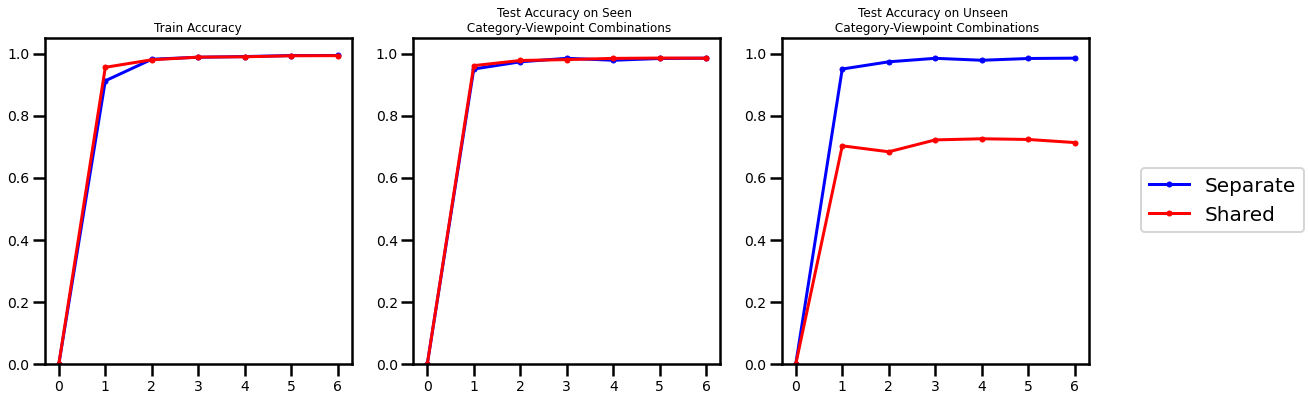

Epoch: 6, Task: viewpoint
---------


  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 6, Task: category
---------


  0%|          | 0/250 [00:00<?, ?it/s]

In [ ]:
for epoch in range(10):
    train_gm_separate = 1
    test_gm_separate = 1
    unseen_test_gm_separate = 1

    for TASK in ['viewpoint','category','shared']:
        print('Epoch: %s, Task: %s'%(epoch,TASK))
        print('---------')
        models[TASK], train_loss, train_gm = train_epoch(models[TASK], TASK, optimizers[TASK])
        best_models[TASK], test_loss, test_gm, best_test_loss, best_test_gm = test_epoch(models[TASK], best_models[TASK], best_test_loss, best_test_gm, TASK)
        unseen_test_loss, unseen_test_gm = unseen_test_epoch(models[TASK], TASK)

        if TASK != 'shared':
            train_gm_separate = train_gm_separate * train_gm
            test_gm_separate = test_gm_separate * test_gm
            unseen_test_gm_separate = unseen_test_gm_separate * test_gm

    all_train_gms['separate'].append(np.sqrt(train_gm_separate))
    all_test_gms['separate'].append(np.sqrt(test_gm_separate))
    all_unseen_test_gms['separate'].append(np.sqrt(unseen_test_gm_separate))
    all_train_gms['shared'].append(train_gm)
    all_test_gms['shared'].append(test_gm)
    all_unseen_test_gms['shared'].append(np.sqrt(unseen_test_gm))
    
    clear_output()
    print('Epoch: %s'%epoch)
    print('---------')
    
    line_labels = ["Separate", "Shared"]

    fig,ax = plt.subplots(1, 3, figsize=(20,6))
    l1 = ax[0].plot(all_train_gms['separate'], color = 'blue', marker = 'o', markersize=5)[0]
    l2 = ax[0].plot(all_train_gms['shared'], color = 'red', marker = 'o', markersize=5)[0]
    ax[0].set_title('Train Accuracy', fontsize=12)
    ax[0].set_ylim(0,1.05)

    ax[1].plot(all_test_gms['separate'], color = 'blue', marker = 'o', markersize=5)
    ax[1].plot(all_test_gms['shared'], color = 'red', marker = 'o', markersize=5)
    ax[1].set_title('Test Accuracy on Seen \n Category-Viewpoint Combinations', fontsize=12)
    ax[1].set_ylim(0,1.05)

    ax[2].plot(all_unseen_test_gms['separate'], color = 'blue', marker = 'o', markersize=5)
    ax[2].plot(all_unseen_test_gms['shared'], color = 'red', marker = 'o', markersize=5)
    ax[2].set_ylim(0,1.05)
    ax[2].set_title('Test Accuracy on Unseen \n Category-Viewpoint Combinations', fontsize=12)
    fig.legend([l1, l2],     # The line objects
            labels=line_labels,   # The labels for each line
            loc="center right",   # Position of legend
            borderaxespad=0.2,    # Small spacing around legend box
            prop={"size":20})
    plt.subplots_adjust(right=0.85)
    plt.show()
